In [1]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, Printf
using Dates, DelimitedFiles, XLSX, DataFrames, Statistics

  Activating project at `~/code/gitHub/CarbonI`
┌ Info: CUDA-enabled GPU(s) detected
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:57
┌ Info: CUDA.CuDevice(0): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:59
┌ Info: CUDA.CuDevice(1): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:59


In [2]:
using  CairoMakie, Interpolations
include(joinpath("../../src/Plots", "CI_colorsNew.jl"))
# Read the Excel data
filename = "../../data/accesstimes_with_roll.xlsx"

sheetname = "Sheet1"
# The readtable function returns a tuple; we convert it to a DataFrame.
data = DataFrame(XLSX.readtable(filename, sheetname))


Row,Unnamed: 0,Time (UTCG),Lat (deg),Lon (deg),Alt (km),required_eta_deg,can_access_0_0
,Any,Any,Any,Any,Any,Any,Any
1,Increasing Lat,2031-06-01T11:13:56,0,4.18,668.197,34.1651,true
2,Increasing Lat,2031-06-02T11:45:28,0,-3.703,668.193,31.157,true
3,Increasing Lat,2031-06-04T11:10:26,0,5.057,668.133,39.0579,true
4,Increasing Lat,2031-06-05T11:41:58,0,-2.826,668.131,24.9543,true
5,Increasing Lat,2031-06-07T11:06:55,0,5.933,668.064,43.1952,true
6,Increasing Lat,2031-06-08T11:38:27,0,-1.949,668.064,17.8973,true
7,Increasing Lat,2031-06-10T11:03:26,0,6.808,668.018,46.6803,true
8,Increasing Lat,2031-06-11T11:34:58,0,-1.077,668.021,10.1574,true
9,Increasing Lat,2031-06-13T10:59:56,0,7.68,667.95,49.6079,true


In [3]:
# Convert the "Time (UTCG)" column from String to DateTime
overpass_times = DateTime.(data[!, "Time (UTCG)"]);
lon = Float32.(data[!, "Lon (deg)"]);
roll = Float32.(data[!, "required_eta_deg"]);

In [13]:
# Compute time in days from start:
delta_days = (data[!, "Time (UTCG)"] .- data[1, "Time (UTCG)"]) ./ Day(1) .+2;
lon_center = 55.5;

dTime * 24 = 881.7674509803923


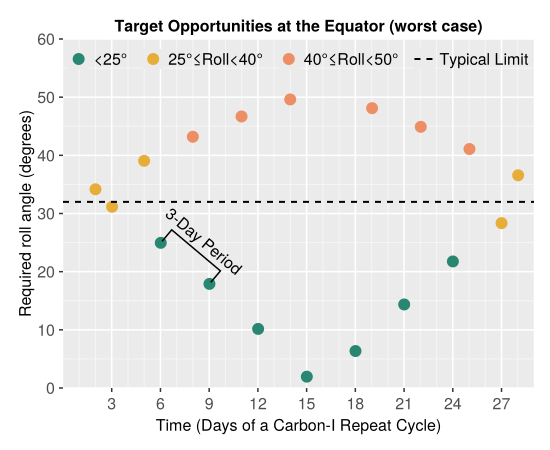

In [15]:
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));

set_theme!(theme_ggplot2())
# 5. Create a Figure and an Axis for the plot using CairoMakie.
fig = Figure(resolution=(550,450))
ax = Axis(fig[1,1];
    ylabel = "Required roll angle (degrees)",
    xlabel= "Time (Days of a Carbon-I Repeat Cycle)",
    xticks=3:3:30,
    title = "Target Opportunities at the Equator (worst case)",
    xminorticks = IntervalsBetween(3),
    )
#
distance = abs.(lon.-lon_center)*111.3;
dd = ones(length(1:30))
ind_25 = findall(0 .< roll .< 25);
#ind_30 = findall(244 .< distance .< 391);
ind_40 = findall( 25 .< roll .< 40);
ind_50 = findall(40 .< roll .< 50);
ind_all = findall(0 .< roll .< 100);

dTime = mean(diff(delta_days[ind_all]))*24;
@show dTime*24

text!(ax,14, 950, text = "Average Time between potential Targets: $( @sprintf("%.0f", dTime) ) hours", align = (:center, :center))
scatter!(ax, delta_days[ind_25], roll[ind_25], markersize=17, color=CarbonI_colors[3],  label = "<25°")
scatter!(ax, delta_days[ind_40], roll[ind_40], markersize=17, color=CarbonI_colors[1],  label = "25°≤Roll<40°")
scatter!(ax, delta_days[ind_50], roll[ind_50], markersize=17, color=CarbonI_colors[10],  label = "40°≤Roll<50°")
#bracket!(ax,delta_days[ind_25[1]], distance[ind_25[1]],delta_days[ind_25[1]], distance[ind_25[1]]; text = "Period length", style = :square)
bracket!(delta_days[ind_25[1]], roll[ind_25[1]],delta_days[ind_25[2]], roll[ind_25[2]], offset = 2, text = "3-Day Period", style = :square, rotation = -0.7)
lines!(ax, [0,29], [32,32], color = :black, linewidth = 2, label="Typical Limit", linestyle = :dash)
axislegend(position = :ct,orientation = :horizontal,)
#leg = Legend(fig, ax, orientation = :horizontal,labelsize=12)
#fig[2, 1] = leg




#lines!(ax, delta_days, abs.(lon.-lon_center)*111.3, color = :blue)
ylims!(ax, 0, 60)
xlims!(ax, 0, 29)
save("../../plots/final/SectionF_TargetRevistOpportunities.pdf", fig)
save("../../plots/final/SectionF_TargetRevistOpportunities.eps", fig)
fig



In [6]:
CarbonI_colors